# Import necessary libraries

In [28]:
import torch
import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Config
from torch.optim import AdamW
import warnings


In [29]:
!pip install -qU transformers

# Data Loader

In [30]:
class ferdousiDataset(Dataset):
  def __init__(self,data_path,tokenizer):

    self.tokenizer = tokenizer

    with open(data_path, "r") as file:
      lines = file.readlines()
    self.lines = lines[2:]

  def __len__(self):

    if len(self.lines)%2 == 1 :
        self.lines.pop()   # ensure we have enven lines
    return len(self.lines)//2

  def __getitem__(self,idx):
      input_poem = self.lines[2*idx].removesuffix("\n")
      target_poem = self.lines[2*idx+1].removesuffix("\n")

      # Tokenize poems
      input = self.tokenizer('<s>' + input_poem + '</s>', max_length=9,truncation=True, padding='max_length',return_tensors='pt')
      target = self.tokenizer('<s>' + target_poem + '</s>', max_length=9,truncation=True, padding='max_length',return_tensors='pt')

      return input['input_ids'],target['input_ids'], input['attention_mask']



In [31]:
tokenizer = AutoTokenizer.from_pretrained(
    "HooshvareLab/gpt2-fa",
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
)

data_path = '/content/ferdousi.txt'

dataset=ferdousiDataset(data_path,tokenizer)

# spilit dataset for training, validation, and testing sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train Size: ",len(train_dataset))
print("Valid Size: ",len(valid_dataset))
print("Test Size: ",len(test_dataset))

Train Size:  34725
Valid Size:  7441
Test Size:  7442


# Train the Model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GPT2LMHeadModel.from_pretrained("HooshvareLab/gpt2-fa").to(device)
optimizer = AdamW(model.parameters(), lr=5e-4)

cuda


In [34]:
num_epochs = 4
Early_Stopping=0

# Training and validation loop
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    val_loss = 0.0

    for inputs, target, attention in tqdm.tqdm(train_loader):
        inputs, target, attention = inputs.to(device), target.to(device), attention.to(device)

        optimizer.zero_grad()
        model.zero_grad()
        outputs = model(input_ids=inputs,labels=target,attention_mask=attention)
        loss=outputs.loss.mean()

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Vlidation Phase
    model.eval()
    with torch.no_grad():
        for inputs, target, attention in val_loader:
            inputs, target, attention = inputs.to(device), target.to(device), attention.to(device)

            outputs = model(inputs,labels=target,attention_mask=attention)
            loss=outputs.loss.mean()
            val_loss += loss.item()


    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    if val_losses[-1] == min(val_losses):
      torch.save(model.state_dict(), 'best_model.pth')
      print("Saved best model")


    if epoch>0 and val_losses[-2] < val_losses[-1]:
      Early_Stopping+=1
      if Early_Stopping>0:
        break;



100%|██████████| 272/272 [01:36<00:00,  2.83it/s]


Epoch 1/4, Train Loss: 6.0183, Validation Loss: 5.7907
Saved best model


100%|██████████| 272/272 [01:35<00:00,  2.84it/s]


Epoch 2/4, Train Loss: 5.6725, Validation Loss: 5.7054
Saved best model


100%|██████████| 272/272 [01:35<00:00,  2.85it/s]


Epoch 3/4, Train Loss: 5.4747, Validation Loss: 5.7044
Saved best model


100%|██████████| 272/272 [01:35<00:00,  2.85it/s]


Epoch 4/4, Train Loss: 5.2239, Validation Loss: 5.7942


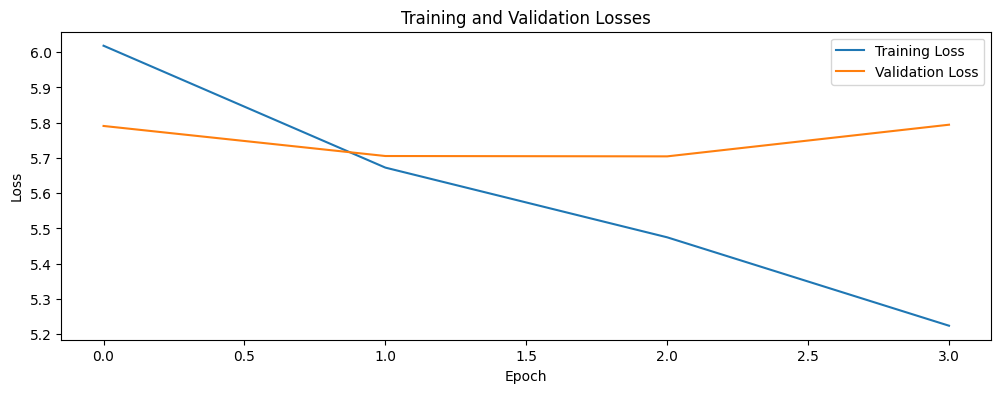

In [35]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Test

In [36]:
import math

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss=0
with torch.no_grad():
    for inputs, target, attention in test_loader:
        inputs, target, attention = inputs.to(device), target.to(device), attention.to(device)

        outputs = model(inputs,labels=target,attention_mask=attention)
        loss=outputs.loss
        test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    test_perplexity = math.exp(test_loss)

print(f"Test Loss: {test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}")

Test Loss: 5.7200, Test Perplexity: 304.9136


# Generate poem

In [37]:
def generate_poem(prompt,model,tokenizer):
    input = tokenizer(text= '<s>' + prompt +'</s>' ,return_tensors='pt').to(device)

    model.eval()
    length= input.input_ids.shape[1]
    print(length)
    temp = len(prompt)
    output_ids = model.generate(input.input_ids,no_repeat_ngram_size=1,top_k=50,max_length=2*length+1,top_p=0.95,min_length=2*length-1,
                                pad_token_id=tokenizer.eos_token_id,do_sample=True,num_return_sequences=1)

    poem = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return poem[:temp] +' / '+poem[temp:]


In [40]:
sample_1="به نام خداوند جان و خرد"
sample_2='رستم برفت آب بخورد'
sample_3='سهراب ای آزاد مرد ایران'
sample_4='ایران و توران جنگیدند'
samples = [sample_1, sample_2, sample_3, sample_4]

for sample in samples:

  generated_poem = generate_poem(sample ,model, tokenizer)
  print(" Poem:")
  print(generated_poem)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


8
 Poem:
به نام خداوند جان و خرد / پرد نشرد س آفریدست گرد پرورد
8


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Poem:
رستم برفت آب بخورد /  بهورد زردستان باد بازجوی
9
 Poem:
سهراب ای آزاد مرد ایران /  را در کرد و فرمان او شاه راهش
6
 Poem:
ایران و توران جنگیدند / گست شدش بر کمر
